# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd

from dataloader.load_regression_data import RegressionDataGenerator

from utils.gaussian_processes.gp_model import GPModel
from utils.get_dummy_data.get_data_from_function import get_df_from_1d_function, split_train_test

2023-02-19 16:14:38.572486: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-19 16:14:39.181406: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-19 16:14:39.181473: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-19 16:14:39.181480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make su

# Data

In [2]:
def fct(x):
    return np.sin(3*x) + 2 * x

x_arr = np.linspace(0, 10, 100)

In [3]:
df = get_df_from_1d_function(fct, x_arr)
x_col = "x"
y_col = "y"

df.head()

,x,y
0,0.00000,0.000000
1,0.10101,0.500434
2,0.20202,0.973675
3,0.30303,1.395006
4,0.40404,1.744444


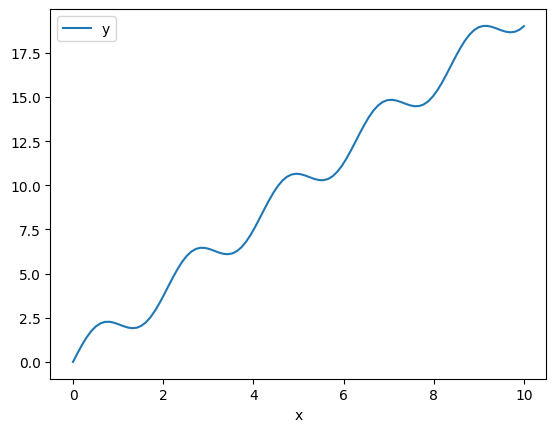

In [4]:
df.plot(x=x_col, y=y_col);

In [5]:
df_observed, df_predict = split_train_test(df, frac=0.5)

In [6]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       50 non-null     float64
 1   y       50 non-null     float64
dtypes: float64(2)
memory usage: 1.2 KB


# Gaussian Process

In [10]:
gp_model = GPModel()
gp_model.fit(df_observed=df_observed, x_col=x_col, y_col=y_col, epochs=1000)

loss = 84.767: 100%|██████████| 1000/1000 [00:11<00:00, 83.38it/s]


# DataGenerator

In [11]:
data_generator = RegressionDataGenerator(gp_model=gp_model,
                                         df_predict=df_predict)

(<Figure size 800x500 with 1 Axes>, <AxesSubplot: >)

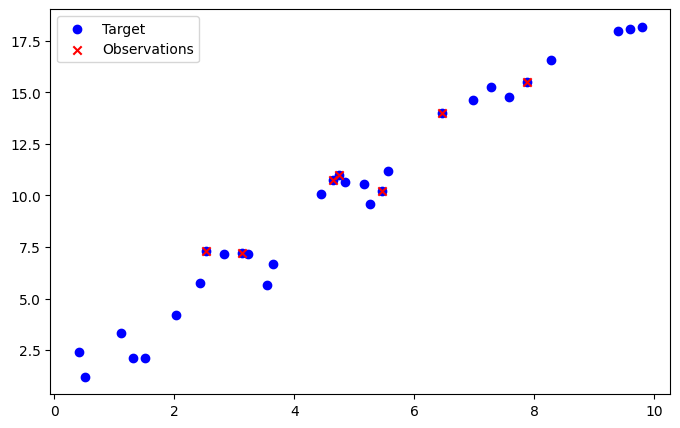

In [12]:
data_generator.plot_first_elt_of_random_batch()

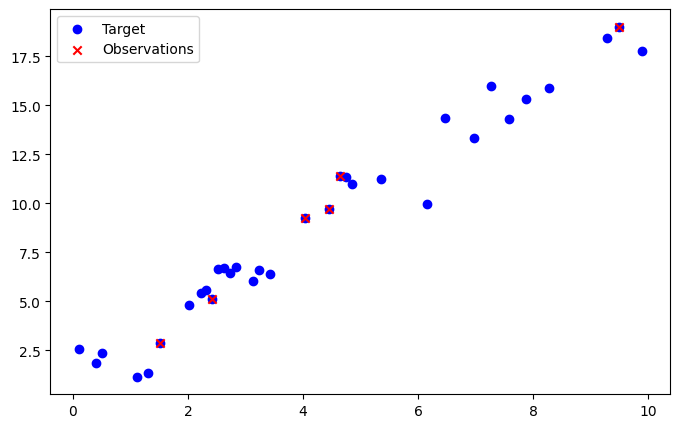

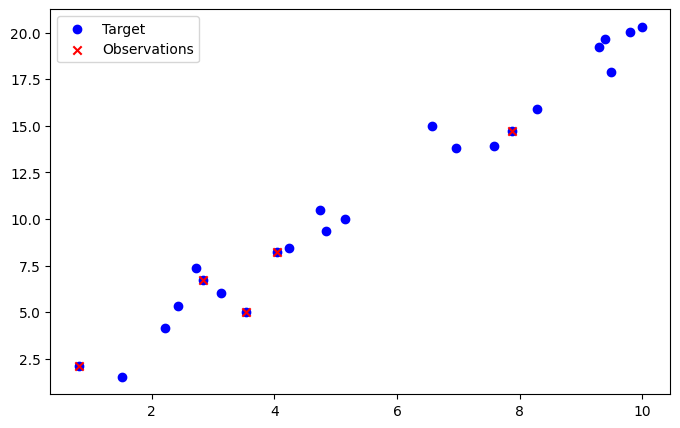

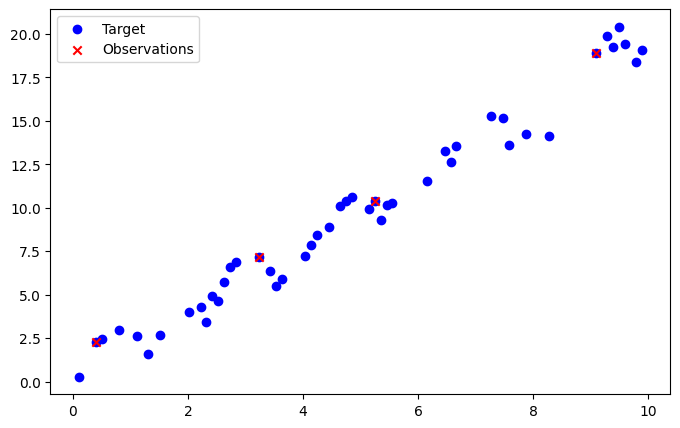

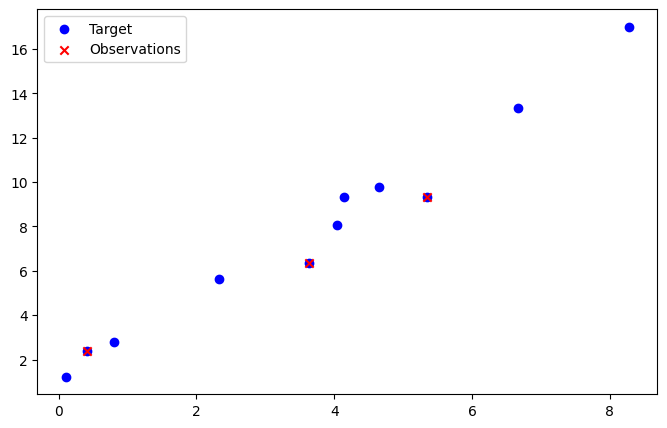

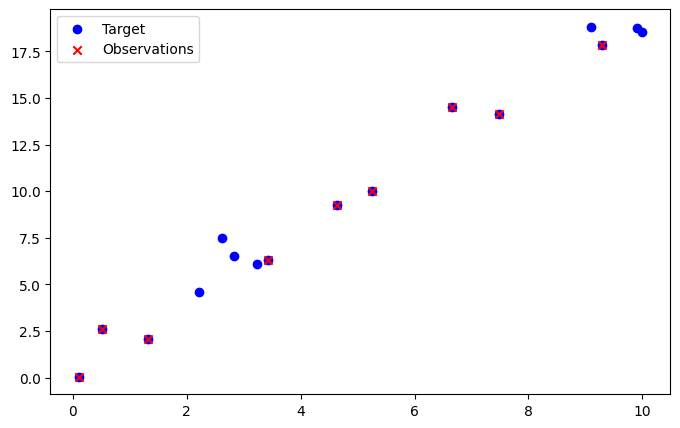

In [13]:
for (context_x, context_y, target_x), target_y in data_generator.train_ds.take(5):
    RegressionDataGenerator.plot_first_elt_of_batch(context_x, context_y, target_x, target_y)

In [15]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from model import ConditionalNeuralProcess

encoder_dims = [500, 500, 500, 500]
decoder_dims = [500, 500, 500, 2]

def loss(target_y, pred_y):
    # Get the distribution
    mu, sigma = tf.split(pred_y, num_or_size_splits=2, axis=-1)
    dist = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    return -dist.log_prob(target_y)

model = ConditionalNeuralProcess(encoder_dims, decoder_dims)
model.compile(loss=loss, optimizer='adam')

In [16]:
model.fit(data_generator.train_ds, validation_data=data_generator.test_ds, epochs=1)

250/250 [==============================] - 136s 546ms/step - loss: 3.0313 - val_loss: 1.3674


In [17]:
from utils.gaussian_processes.plot_gp_utils import plot_preds_from_ds_test

1/1 [==============================] - 0s 31ms/step


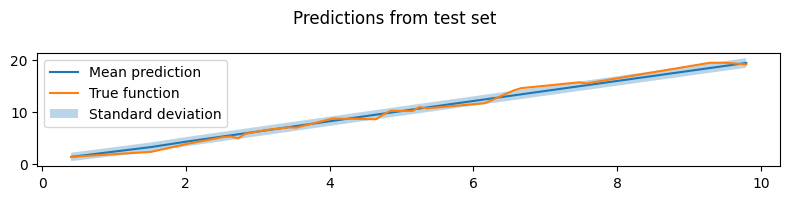

In [18]:
fig = plot_preds_from_ds_test(model, ds_test=data_generator.test_ds, num_samples=1)

1/1 [==============================] - 0s 28ms/step


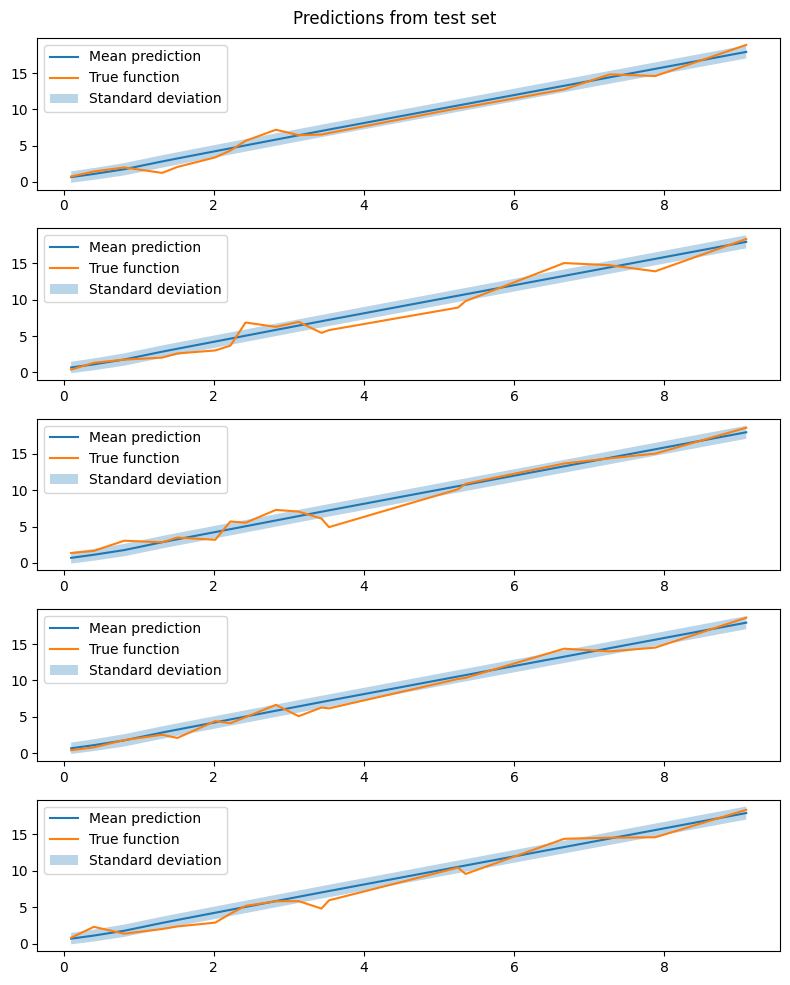

In [19]:
fig = plot_preds_from_ds_test(model, ds_test=data_generator.test_ds, num_samples=5)